In [1]:
RETRAIN = True

In [2]:
!pip install xmltodict

In [9]:
paths = {'PKLot': ["PKLot/PKLot/PKLotSegmented/", "splits/PKLot/train.txt", "splits/PKLot/test.txt"],
         'CNR-EXT': ['CNR-EXT-Patches-150x150/PATCHES', 'splits/CNRPark-EXT/train.txt', 'splits/CNRPark-EXT/test.txt'],
         'CNRPark': ['CNRPark-Patches-150x150/', 'splits/CNRParkAB/train.txt', 'splits/CNRParkAB/val.txt']}

In [10]:
import os   
import cv2
import torch
import argparse
import xmltodict
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score

def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

class Data:
    def __init__(self, img_path, target_path, transforms = None):
        with open(target_path, 'r') as f:
            lines = f.readlines()
            self.img_list = [os.path.join(img_path, i.split()[0]) for i in lines]
            self.label_list = [i.split()[1] for i in lines]
            self.transforms = transforms
    
    def __getitem__(self, index):
        try:
            img_path = self.img_list[index]
            img = Image.open(img_path)
            img = self.transforms(img)
            label = self.label_list[index]
        except:
            return None
        return img, label
    
    def __len__(self):
        return len(self.label_list)

In [4]:
def imshow(train_loader):
    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    img = torchvision.utils.make_grid(images)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
class AlexNet(nn.Module):
  def __init__(self, num_classes=2, init_weights=False):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 48, 11, 4, 2), 
        nn.ReLU(inplace=True),
        nn.MaxPool2d(3, 2), 
        nn.Conv2d(48, 128, kernel_size=5, padding=2), 
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),        
        nn.Conv2d(128, 192, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(192, 192, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(192, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.classifier = nn.Sequential(
      nn.Dropout(p=0.5),
      nn.Linear(128 * 6 * 6, 2048),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(2048, 2048),
      nn.ReLU(inplace=True),
      nn.Linear(2048, num_classes),
    )
    if init_weights:
      self._initialize_weights()
  def forward(self, x):
      x = self.features(x)
      x = x.view(x.size(0), -1)
      return self.classifier(x)

  def _initialize_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
              if m.bias is not None:
                  nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
              nn.init.normal_(m.weight, 0, 0.01)
              nn.init.constant_(m.bias, 0) 


class mAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.input_channel = 3
        self.num_output = num_classes
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=self.input_channel, out_channels= 16, kernel_size= 11, stride= 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels= 16, out_channels= 20, kernel_size= 5, stride= 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels= 20, out_channels= 30, kernel_size= 3, stride= 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.layer4 = nn.Sequential(
            nn.Linear(30*3*3, out_features=48),
            nn.ReLU(inplace=True)
        )
        self.layer5 = nn.Sequential(
            nn.Linear(in_features=48, out_features=2)
        )

    def forward(self, x):
        x = self.layer3(self.layer2(self.layer1(x)))
        x = x.view(x.size(0), -1)
        x = self.layer5(self.layer4(x))
        m = nn.Softmax(dim=1)
        return m(x)

In [16]:
def train(epoch, img_path, target_path, transform, net, criterion, device):
    train_dataset = Data(img_path, target_path, transform)
    train_loader = DataLoader(train_dataset, batch_size=64, \
            shuffle=True, num_workers=0,drop_last=False, collate_fn=collate_fn)
    epochLoss = []
    for ep in range(epoch):  
        if ep >= 12:
            learning_rate = 0.0025
        elif ep >= 6:
            learning_rate = 0.005
        else:
            learning_rate = 0.01
        running_loss = 0.0
        print("Epoch {}.".format(ep+1))
        for i, data in enumerate(train_loader,1):
            inputs, labels = data
            labels = list(map(int, labels))
            labels = torch.Tensor(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            print("Epoch {}.\tBatch {}.\tLoss = {:.3f}.".format(ep+1, i+1, running_loss))
            if i % len(train_loader) == len(train_loader) - 1:    
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / len(train_loader)))
                epochLoss.append(running_loss)
                running_loss = 0.0

    print('Finished Training.')
    return epochLoss


In [11]:
def test(img_path, target_path, transform, net, device):
    print("\nTesting starts now...")
    test_dataset = Data(img_path, target_path, transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, \
                            num_workers=0, collate_fn=collate_fn)
    correct = 0
    total = 0
    item = 1
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            print("Testing on batch {}".format(item))
            labels = list(map(int, labels))
            labels = torch.Tensor(labels)
            images = images.to(device)
            labels = labels.to(device)
            y_pred.append(labels)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.append(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            item += 1
    return (correct/total), roc_auc_score(y_true, y_pred)


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),  # normalize to [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

### Reprodução Tabela 2 do artigo do cnrpark

In [12]:
paths

{'PKLot': ['PKLot/PKLot/PKLotSegmented/',
  'splits/PKLot/train.txt',
  'splits/PKLot/test.txt'],
 'CNR-EXT': ['CNR-EXT-Patches-150x150/PATCHES',
  'splits/CNRPark-EXT/train.txt',
  'splits/CNRPark-EXT/test.txt'],
 'CNRPark': ['CNRPark-Patches-150x150/',
  'splits/CNRParkAB/train.txt',
  'splits/CNRParkAB/val.txt']}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


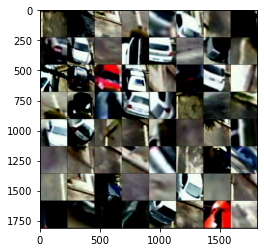

In [13]:
train_dataset = Data(paths['PKLot'][0], "splits/PKLot/UFPR04_train.txt", transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=False)
imgs, labels = train_loader.__iter__().__next__()
imshow(train_loader)

In [14]:
net = mAlexNet().to(device)
criterion = nn.CrossEntropyLoss()

In [17]:
if RETRAIN:
    loss = train(18, paths['PKLot'][0], "splits/PKLot/UFPR04_train.txt", transform, net, criterion, device)
    PATH = 'ufpr04Train.pth'
    torch.save(net.state_dict(), PATH)
    net.load_state_dict(torch.load(PATH))
else:
    PATH = './model.pth'
    net.load_state_dict(torch.load(PATH))

Epoch 1.
Epoch 1.	Batch 2.	Loss = 0.693.
Epoch 1.	Batch 3.	Loss = 1.378.
Epoch 1.	Batch 4.	Loss = 2.078.
Epoch 1.	Batch 5.	Loss = 2.762.
Epoch 1.	Batch 6.	Loss = 3.461.
Epoch 1.	Batch 7.	Loss = 4.152.
Epoch 1.	Batch 8.	Loss = 4.849.
Epoch 1.	Batch 9.	Loss = 5.550.
Epoch 1.	Batch 10.	Loss = 6.244.
Epoch 1.	Batch 11.	Loss = 6.941.
Epoch 1.	Batch 12.	Loss = 7.639.
Epoch 1.	Batch 13.	Loss = 8.329.
Epoch 1.	Batch 14.	Loss = 9.015.
Epoch 1.	Batch 15.	Loss = 9.711.
Epoch 1.	Batch 16.	Loss = 10.417.
Epoch 1.	Batch 17.	Loss = 11.105.
Epoch 1.	Batch 18.	Loss = 11.799.
Epoch 1.	Batch 19.	Loss = 12.498.
Epoch 1.	Batch 20.	Loss = 13.199.
Epoch 1.	Batch 21.	Loss = 13.899.
Epoch 1.	Batch 22.	Loss = 14.599.
Epoch 1.	Batch 23.	Loss = 15.301.
Epoch 1.	Batch 24.	Loss = 15.995.
Epoch 1.	Batch 25.	Loss = 16.695.
Epoch 1.	Batch 26.	Loss = 17.384.
Epoch 1.	Batch 27.	Loss = 18.079.
Epoch 1.	Batch 28.	Loss = 18.774.
Epoch 1.	Batch 29.	Loss = 19.471.
Epoch 1.	Batch 30.	Loss = 20.171.
Epoch 1.	Batch 31.	Loss = 2

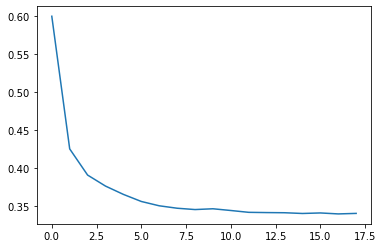

In [22]:
plt.plot([i/len(train_loader) for i in loss])

In [24]:
accuracy, auc = test(paths['PKLot'][0], "splits/PKLot/UFPR04_test.txt", transform, net, device)
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format((paths['PKLot'][0]).split('.')[0], ("splits/PKLot/UFPR04_test.txt").split('.')[0], accuracy))


Testing starts now...
Testing on batch 1
Testing on batch 2
Testing on batch 3
Testing on batch 4
Testing on batch 5
Testing on batch 6
Testing on batch 7
Testing on batch 8
Testing on batch 9
Testing on batch 10
Testing on batch 11
Testing on batch 12
Testing on batch 13
Testing on batch 14
Testing on batch 15
Testing on batch 16
Testing on batch 17
Testing on batch 18
Testing on batch 19
Testing on batch 20
Testing on batch 21
Testing on batch 22
Testing on batch 23
Testing on batch 24
Testing on batch 25
Testing on batch 26
Testing on batch 27
Testing on batch 28
Testing on batch 29
Testing on batch 30
Testing on batch 31
Testing on batch 32
Testing on batch 33
Testing on batch 34
Testing on batch 35
Testing on batch 36
Testing on batch 37
Testing on batch 38
Testing on batch 39
Testing on batch 40
Testing on batch 41
Testing on batch 42
Testing on batch 43
Testing on batch 44
Testing on batch 45
Testing on batch 46
Testing on batch 47
Testing on batch 48
Testing on batch 49
Testin

c:\Users\GODZILLA\anaconda3\lib\site-packages\sklearn\utils\multiclass.py:150: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y = np.asarray(y)
c:\Users\GODZILLA\anaconda3\lib\site-packages\sklearn\utils\multiclass.py:154: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tenso

AttributeError: 'bool' object has no attribute 'any'

In [25]:
accuracy

NameError: name 'accuracy' is not defined

In [36]:
listi = []
names = []
for root, dirs, files in os.walk("PKLot/PKLot/PKLotSegmented/UFPR04/Sunny/2012-12-12"):
  for fil in files:
    if '2012-12-12_12_40_08' in fil:
      names.append(fil)
      if 'Empty' in root:
        listi.append((transform(Image.open(root + '/' + fil)), '0'))
      else:
        listi.append((transform(Image.open(root + '/' + fil)), '1'))
        
dl = DataLoader(listi, batch_size=1, shuffle=True, drop_last=False)

In [38]:
preds = []
correct = 0
total = 0
item = 1
for a in dl:
  images, labels = a
  labels = list(map(int, labels))
  labels = torch.Tensor(labels)
  images = images.to(device)
  labels = labels.to(device)

  outputs = net(images)
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
  item += 1
  preds.append(predicted)

In [39]:
accuracy = correct/total
print("\nThe accuracy of training on '{}' and testing on '{}' is {:.3f}.".format(("splits/CNRParkAB/even.txt").split('.')[0], ("splits/CNRParkAB/odd.txt").split('.')[0], accuracy))


The accuracy of training on 'splits/CNRParkAB/even' and testing on 'splits/CNRParkAB/odd' is 0.786.


In [41]:
with open('PKLot/PKLot/PKLot/UFPR04/Sunny/2012-12-12/2012-12-12_12_40_08.xml') as f:
  content=f.read()
  d = xmltodict.parse(content)
  coord = []
  for fil in names:
    coo = d['parking']['space'][int(fil[-7:-4])-1]['contour']['point']
    coord.append([[int(x['@x']), int(x['@y'])] for x in coo])

In [42]:
img = cv2.imread("PKLot/PKLot/PKLot/UFPR04/Sunny/2012-12-12/2012-12-12_12_40_08.jpg")

for i, co in enumerate(coord):
  pts = np.array(co, np.int32)
  pts = pts.reshape((-1,1,2))
  if listi[i][1] == '0':
    c = (0,255,255)
  else:
    c = (255, 0, 0)
  cv2.polylines(img,[pts],True,c, 2)

while(1):
     
    cv2.imshow('image', img)
    if cv2.waitKey(20) & 0xFF == 27:
        break
cv2.destroyAllWindows()